In [1]:
from collections import Counter
import os
from glob import glob
import re

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

## Create df with performance data

### Clone map

In [2]:
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'], 
        ['E', 's1', 'P9855_2085_S108_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2089_S112_L004_ac.txt', 'ss2'],
        ['A', 's3', 'P9855_2090_S113_L004_ac.txt', 'ss3'],
        ['D', 's4', 'P9855_2091_S114_L004_ac.txt', 'ss4'],
        ['E', 's5', 'P9855_2093_S116_L005_ac.txt', 'ss5'],
        ['D', 's6', 'P9855_2096_S119_L005_ac.txt', 'ss6'],
        ['F', 's7', 'P9855_2101_S124_L006_ac.txt', 'ss7'],
        ['F', 's8', 'P9855_2102_S125_L006_ac.txt', 'ss8'],
        ['B', 's9', 'P9855_2104_S127_L006_ac.txt', 'ss9'],
        ['C', 's10', 'P9855_2110_S133_L007_ac.txt', 'ss10'],
        ['C', 's11', 'P9855_2111_S134_L007_ac.txt', 'ss11'],
        ['B', 's12', 'P9855_2112_S135_L007_ac.txt', 'ss12']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_218.clean.dedup_ac.txt,ss0
1,E,s1,P9855_2085_S108_L004_ac.txt,ss1
2,A,s2,P9855_2089_S112_L004_ac.txt,ss2
3,A,s3,P9855_2090_S113_L004_ac.txt,ss3
4,D,s4,P9855_2091_S114_L004_ac.txt,ss4
5,E,s5,P9855_2093_S116_L005_ac.txt,ss5
6,D,s6,P9855_2096_S119_L005_ac.txt,ss6
7,F,s7,P9855_2101_S124_L006_ac.txt,ss7
8,F,s8,P9855_2102_S125_L006_ac.txt,ss8
9,B,s9,P9855_2104_S127_L006_ac.txt,ss9


In [3]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [4]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

### Load info from mt-SCITE runs

In [7]:
scite_input_path = f'../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/'

scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))

# Get log likelihood scores and n trees
exp_std = []
lhood = []
n_trees = []

#for filename in sorted(scite_stdout_filenames, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
for filename in sorted(scite_stdout_filenames):
    print(filename)
    name = os.path.basename(filename).rsplit('.', 1)[0].rsplit('.', 1)[0]
    #print(name)
    exp_std.append(name)
    #print(files)
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
            #print(lhood)
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]
            #print(n_trees)
            

../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_2.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_3.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_4.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_5.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_6.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_7.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_8.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00005_9.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00009_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.00009_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000

../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.0009_8.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.0009_9.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_2.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_3.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_4.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_5.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_6.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_7.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_8.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.001_9.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/stdout/0.002_1.stdout.

### Load info from pmats

In [8]:

pmat_input_path = f'../../data/P9855_matrix_output_mrate_1000/'

pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))

pmat_names = []
n_pmat_rows = []

for filename in sorted(pmats):
#for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).rsplit('.', 1)[0]
    print(name)
    file = open(filename, "r")
    n = len(file.readlines())
    n_pmat_rows.append(n)
    pmat_names.append(name)

# store in a dict
pmat_info = {pmat_names[i]: n_pmat_rows[i] for i in range(len(pmat_names))}


0.00005
0.00009
0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001
0.002
0.005
0.025
0.03


In [9]:
pmat_info

{'0.00005': 878,
 '0.00009': 217,
 '0.0001': 176,
 '0.0002': 64,
 '0.0003': 40,
 '0.0004': 35,
 '0.0005': 34,
 '0.0006': 30,
 '0.0007': 28,
 '0.0008': 26,
 '0.0009': 24,
 '0.001': 24,
 '0.002': 22,
 '0.005': 19,
 '0.025': 6,
 '0.03': 3}

### Create df containing info from mt-SCITE and pmat

In [10]:
samples = 13

performance = pd.DataFrame(exp_std)
performance['lhood'] = lhood
performance['lhood'] = performance['lhood'].astype(float)

performance['n trees'] = n_trees
performance['error_rate'] = performance[0].str.split('_').str.get(0)

performance = performance.rename(columns={0: 'run'})
performance = performance.set_index('run')

runs = performance.index.tolist()
performance = performance.sort_index()

performance['n_muts'] = performance['error_rate'].map(pmat_info)

performance['entries'] = performance['n_muts']*samples

performance['lhood_entries'] = performance['lhood']/performance['entries']

In [11]:
performance

,lhood,n trees,error_rate,n_muts,entries,lhood_entries
run,,,,,,
0.00005_1,-10091.911803,6,0.00005,878,11414,-0.884170
0.00005_10,-10232.207192,40,0.00005,878,11414,-0.896461
0.00005_2,-10234.038356,30,0.00005,878,11414,-0.896622
0.00005_3,-9714.092493,1,0.00005,878,11414,-0.851068
0.00005_4,-9445.777507,71,0.00005,878,11414,-0.827561
...,...,...,...,...,...,...
0.03_5,-4.461833,1,0.03,3,39,-0.114406
0.03_6,-4.461833,1,0.03,3,39,-0.114406
0.03_7,-4.461833,1,0.03,3,39,-0.114406


### Read trees

In [12]:
MAX_TREES_PER_ERROR_RATE = 100
all_trees = {}
for run, n in zip(runs, n_trees):
    all_trees[run] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        #print(n)
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/{run}_map{idx}.gv' 
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[run].append(tree)
        #print(error_rate)

In [13]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_11511/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


# Avg purity of nodes with >1 sample

In [21]:
import warnings
warnings.filterwarnings('ignore')

performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    #n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        #print(p)
        
        # exclude mutations shared by all clones
        p = p.T
        p = p.mask((p.A > 0) & (p.B > 0) & (p.C > 0) & (p.D > 0) & (p.E > 0) & (p.F > 0))
        p = p.dropna().T
        
        
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 286
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 275
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 508
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 610
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 574
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 868
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 540
!! possible mutation in a leaf: not found 319
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 751
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 59
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 640
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 819
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 311
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 862
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 35
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 502
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 116
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 453
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 555
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 232
!! possible mutation in a leaf: not found 271
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 555
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 232
!! possible mutation in a leaf: not found 271
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 555
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 232
!! possible mutation in a leaf: not found 271
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not found 246
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 849
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not found 246
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 226
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 755
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 275
!! possible mutation in a leaf: not found 244
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 108
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 231
!! possible mutation in a leaf: not found 118
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 301
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 136
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 218
!! possible mutation in a leaf: not found 88
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 245
!! possible mutation in a leaf: not found 492
!! possible mutation in a leaf: not found 244
!! possible mutation in a leaf: not found 576
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 232
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 108
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 231
!! possible mutation in a leaf: not found 118
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 663
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 114
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 524
!! possible mutation in a leaf: not found 679
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 664
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 663
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 136
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 88
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 108
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 231
!! possible mutation in a leaf: not found 118
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 555
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 136
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 88
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 516
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 603
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 490
!! possible mutation in a leaf: not found 45
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 365
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 114
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 555
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 136
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 231
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 88
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 165
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 108
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 118
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 136
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 231
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 88
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 108
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 118
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 73
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 136
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 314
!! possible mutation in a leaf: not found 231
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 875
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 88
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 108
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 87
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 118
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 482
!! possible mutation in a leaf: not found 594
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 456
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 773
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 73
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 592
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 525
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 578
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 842
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 62
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 874
!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 796
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 736
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 794
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 221
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 774
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 576
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 307
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 774
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 640
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 658
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 825
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 774
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 307
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 307
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 319
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 307
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found 161
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 781
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found 161
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 275
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 428
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 576
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 221
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 319
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 307
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 319
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 64
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found 161
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found 161
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 275
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not found 472
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found 161
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 275
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 328
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not found 514
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 852
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 419
!! possible mutation in a leaf: not found 296
!! possible mutation in a leaf: not found 20
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 541
!! possible mutation in a leaf: not found 269
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 455
!! possible mutation in a leaf: not found 179
!! possible mutation in a leaf: not found 161
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 798
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 359
!! possible mutation in a leaf: not found 479
!! possible mutation in a leaf: not found 601
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 639
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 323
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 475
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 848
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 346
!! possible mutation in a leaf: not found 217
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 328
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 817
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 685
!! possible mutation in a leaf: not found 280
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 703
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 589
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 170
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 498
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 840
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 744
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 637
!! possible mutation in a leaf: not found 785
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 86
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 371
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 563
!! possible mutation in a leaf: not found 608
!! possible mutation in a leaf: not found 183
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 358
!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 358
!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 4
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 6
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not found 303
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 358
!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 358
!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 671
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 519
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 358
!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 519
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 4
!! possible mutation in a leaf: not found 512
!! possible mutation in a leaf: not found 6
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not found 303
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 529
!! possible mutation in a leaf: not found

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 587
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 519
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 358
!! possible mutation in a leaf: not found 527
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 519
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 620
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 518
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 263
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 647
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 870
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 531
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 357
!! possible mutation in a leaf: not found 519
!! possible mutation in a leaf: not found 169
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 324
!! possible mutation in a leaf: not found 78
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 347
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 634
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 319
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 109
!! possible mutation in a leaf: not found 595
!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 663
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 71
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not found 487
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 3
!! possible mutation in a leaf: not found 660
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 498
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 406
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 458
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 490
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 600
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 808
!! possible mutation in a leaf: not found 576
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 275
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 717
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 612
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 405
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 736
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 736
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 389
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 634
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 523
!! possible mutation in a leaf: not found 109
!! possible mutation in a leaf: not found 595
!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 663
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 71
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 3
!! possible mutation in a leaf: not found 660
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 498
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 406
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 490
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 600
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 717
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 612
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 572
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 644
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 264
!! possible mutation in a leaf: not found 203
!! possible mutation in a leaf: not found 221
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 736
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 389
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 546
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 736
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 389
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 575
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 270
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 634
!! possible mutation in a leaf: not found 12
!! possible mutation in a leaf: not found 109
!! possible mutation in a leaf: not found 595
!! possible mutation in a leaf: not found 561
!! possible mutation in a leaf: not found 663
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 71
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 128
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 247
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 3
!! possible mutation in a leaf: not found 660
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 52
!! possible mutation in a leaf: not found 498
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 809
!! possible mutation in a leaf: not found 416
!! possible mutation in a leaf: not found 287
!! possible mutation in a leaf: not found 406
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 520
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 689
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 548
!! possible mutation in a leaf: not found 714
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 600
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 399
!! possible mutation in a leaf: not found 343
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 797
!! possible mutation in a leaf: not found 799
!! possible mutation in a leaf: not found 26
!! possible mutation in a leaf: not found 515
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 557
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 726
!! possible mutation in a leaf: not found 824
!! possible mutation in a leaf: not found 681
!! possible mutation in a leaf: not found 841
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 717
!! possible mutation in a leaf: not found 463
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 445
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 612
!! possible mutation in a leaf: not found 835
!! possible mutation in a leaf: not found 330
!! possible mutation in a leaf: not found 513
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 572
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not

!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 837
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 838
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 630
!! possible mutation in a leaf: not found 351
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 656
!! possible mutation in a leaf: not found 152
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 846
!! possible mutation in a leaf: not found 736
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 780
!! possible mutation in a leaf: not found 389
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 777
!! possible mutation in a leaf: not found 727
!! possible mutation in a leaf: no

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 229
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 229
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 229
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not found 382
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 762
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 617
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 94
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 791
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 485
!! possible mutation in a leaf: not found 831
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 36
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 732
!! possible mutation in a leaf: not found 199
!! possible mutation in a leaf: not found 873
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 404
!! possible mutation in a leaf: not found 385
!! possible mutation in a leaf: not found 268
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 750
!! possible mutation in a leaf: not found 202
!! possible mutation in a leaf: not found 142
!! possible mutation in a leaf: not found 116
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 717
!! possible mutation in a leaf: not found 286
!! possible mutation in a leaf: not found 423
!! possible mutation in a leaf: not found 684
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 657
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 635
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 635
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 866
!! possible mutation in a leaf: not found 628
!! possible mutation in a leaf: not found 635
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 212
!! possible mutation in a leaf: not found 857
!! possible mutation in a leaf: not found 861
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 488
!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 814
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not f

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 851
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 632
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 239
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fo

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 806
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 821
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 66
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 16
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 56
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not foun

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 56
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 56
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 855
!! possible mutation in a leaf: not found 208
!! possible mutation in a leaf: not found 409
!! possible mutation in a leaf: not found 92
!! possible mutation in a leaf: not found 876
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 227
!! possible mutation in a leaf: not found 444
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 499
!! possible mutation in a leaf: not found 478
!! possible mutation in a leaf: not found 262
!! possible mutation in a leaf: not found 56
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 225
!! possible mutation in a leaf: not found 749
!! possible mutation in a leaf: not found 549
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 427
!! possible mutation in a leaf: not found 435
!! possible mutation in a leaf: not fou

!! possible mutation in a leaf: not found 130
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 130
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 195
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 195
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 195
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 195
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 195
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 98
!! possible mutation in a leaf: not found 195


!! possible mutation in a leaf: not found 133
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 133
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 133
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 133
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 133
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 133
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 68
!! possible mutation in a leaf: not found 8
!! possibl

!! possible mutation in a leaf: not found 68
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 115
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 68
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 115
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 68
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 115
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 68
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 115
!! possible mutation in a leaf: not found 101
!! possible mutation in a leaf: not found 68
!! possible mutation in a leaf: not found 46
!! pos

!! possible mutation in a leaf: not found 146
!! possible mutation in a leaf: not found 146
!! possible mutation in a leaf: not found 67
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 151
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 17

In [19]:
# performance['avg_purity_more_than_one_sample'] = 0
# performance['frac_purity_100_more_than_one_sample'] = 0
# for error_rate, trees in all_trees.items():
#     avg_purities = []
#     frac_purities_100 = []
#     n_purities_100 = []
#     for t in trees:
#         #print(error_rate, get_root_node(t))
#         #print(error_rate)
#         #print(get_root_node(t))
        
#         #print(root_node)
#         clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        
#         # which nodes have more than one sample
#         more_than_one_sample = clones_count.sum(axis=0) > 1
#         #print(more_than_one_sample)
        
#         # p is a matrix with rows = clones and columns = nodes.
#         # included nodes are those attached to > 1 sample
#         # the values in p are the clone purities in each node
#         p = purity(clones_count).loc[:, more_than_one_sample]
#         # print p before root node is removed
#         #print(p)
        
#         # Drop root node since it is attached to all samples
#         # Get the root node
#         root_node = str(get_root_node(t))
#         # Get the index of the root node
#         root_idx = list(p.columns).index(root_node)
#         #print(root_idx)
#         # drop the root node 
#         p = p.drop(p.columns[[root_idx]],axis = 1)
#         # Check that root node is removed
#         #print(p)
        
#         # Average purity
#         avg_purity = p.max(axis=0).mean()
#         avg_purities.append(avg_purity)
#         #print(avg_purities)
#         # Fraction of nodes with 100% purity
#         is_purity_100 = np.isclose(p.max(axis=0), 1.0)
#         frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
#         frac_purities_100.append(frac_purity_100)
        
#     performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
#     performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

# Clone coverage at full purity

In [20]:
# performance['min_clone_coverage'] = np.nan
# performance['avg_clone_coverage'] = np.nan
# for error_rate, trees in all_trees.items():
#     t = trees[0]

#     clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
#     p = purity(clones_count)
#     is_pure = p.max(axis=0) == 1.0
#     coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
#     print(error_rate, '\n', coverage_per_clone, '\n---')
#     min_coverage = coverage_per_clone.min()
#     avg_coverage = coverage_per_clone.drop('bulk').mean()
#     performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
#     performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

In [22]:
performance

,lhood,n trees,error_rate,n_muts,entries,lhood_entries,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample,min_clone_coverage,avg_clone_coverage
run,,,,,,,,,,
0.00005_1,-10091.911803,6,0.00005,878,11414,-0.884170,0.852546,0.729167,0.5,0.666667
0.00005_10,-10232.207192,40,0.00005,878,11414,-0.896461,0.699134,0.536364,0.5,0.750000
0.00005_2,-10234.038356,30,0.00005,878,11414,-0.896622,0.576728,0.176829,0.5,0.666667
0.00005_3,-9714.092493,1,0.00005,878,11414,-0.851068,0.458756,0.000000,0.5,0.500000
0.00005_4,-9445.777507,71,0.00005,878,11414,-0.827561,0.483073,0.099415,0.5,0.583333
0.00005_5,-10329.556291,24,0.00005,878,11414,-0.904990,0.530695,0.094595,0.5,0.583333
0.00005_6,-10438.374557,14,0.00005,878,11414,-0.914524,0.380000,0.000000,0.5,0.500000
0.00005_7,-10409.901291,12,0.00005,878,11414,-0.912029,0.488498,0.000000,0.5,0.500000
0.00005_8,-9900.477680,1,0.00005,878,11414,-0.867398,0.441395,0.071942,0.5,0.666667


# Plots

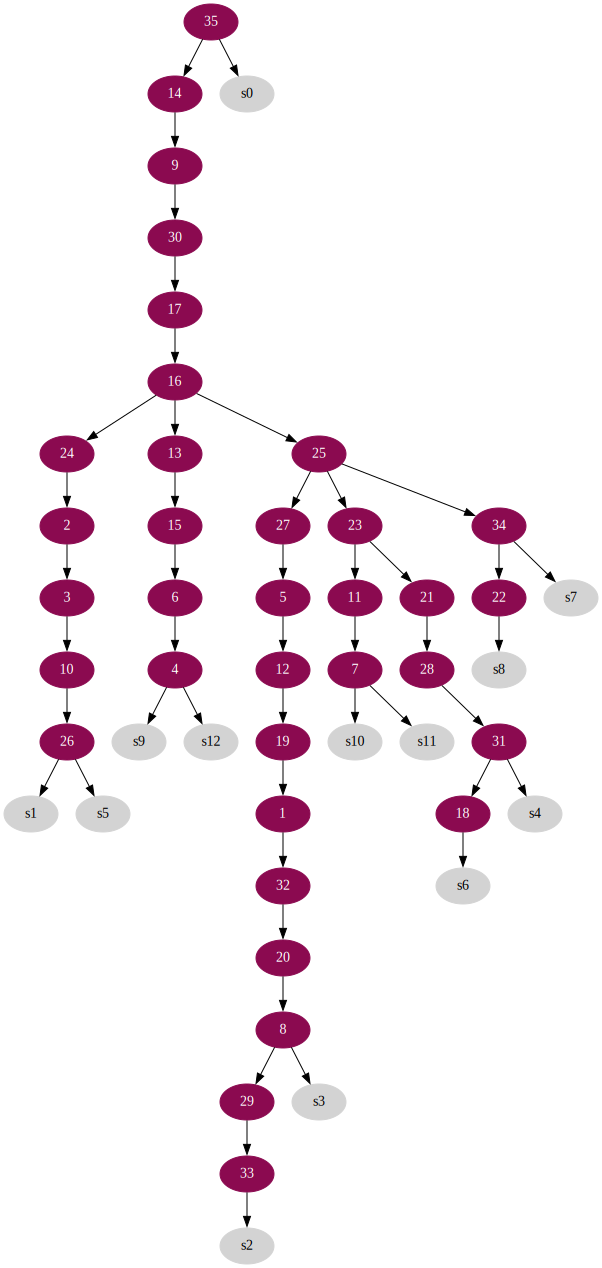

In [23]:
# Plot a tree

Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/0.0005_10_map0.gv')

In [24]:
#pd.set_option('display.max_rows', None)
#performance

## Tree Likelihood

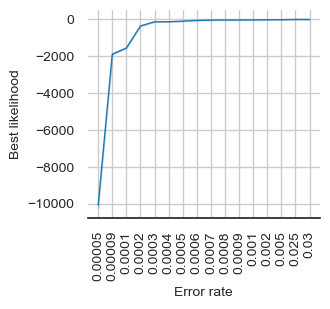

In [27]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="lhood", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood')
    plt.xlabel('Error rate')

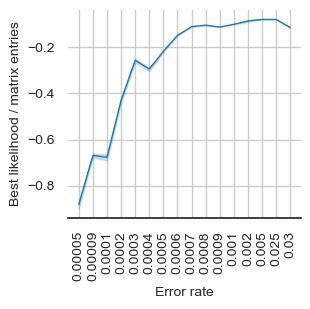

In [28]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="lhood_entries", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood / matrix entries')
    plt.xlabel('Error rate')


## Average purity

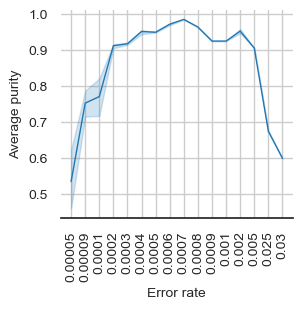

In [30]:

with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="error_rate", y="avg_purity_more_than_one_sample", markersize=4, lw=1)
    #ax.set_ylim(0.4, 0.9)
    plt.grid(axis='both')
    plt.xticks(rotation=90)
    plt.ylabel('Average purity')
    plt.xlabel('Error rate')
    
    
#plt.savefig(f'../../data/simulated_figures/avg_purity_{exp}.svg', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(f'../../data/simulated_figures/avg_purity_{exp}.jpg', dpi=300, bbox_inches='tight', transparent=True)